# Setup
First we need to install keras_cv and import any packages we will use.

In [ ]:
!pip install git+https://github.com/keras-team/keras-cv -q

In [ ]:
import keras_cv
from keras_cv.metrics import coco
import tensorflow as tf
import math
import numpy as np
import seaborn as sns
import random

Next we need to produce random bounding boxes to benchmark against.

In [ ]:
def produce_random_data(include_confidence=False, num_images=128, num_classes=20):
  """Generates a fake list of bounding boxes for use in this test.

  Returns:
    a tensor list of size [128, 25, 5/6].  This represents 128 images, 25 bboxes
      and 5/6 dimensions to represent each bbox depending on if confidence is
      set.
  """
  images = []
  for _ in range(num_images):
    num_boxes = math.floor(25 * random.uniform(0, 1))
    classes = np.floor(np.random.rand(num_boxes, 1) * num_classes)
    bboxes = np.random.rand(num_boxes, 4)
    boxes = np.concatenate([bboxes, classes], axis=-1)
    if include_confidence:
      confidence = np.random.rand(num_boxes, 1)
      boxes = np.concatenate([boxes, confidence], axis=-1)
    images.append(
        keras_cv.utils.bounding_box.xywh_to_corners(
            tf.constant(boxes, dtype=tf.float32)))

  images = [
      keras_cv.utils.bounding_box.pad_bounding_box_batch_to_shape(x, [25, images[0].shape[1]])
      for x in images
  ]
  return tf.stack(images, axis=0)

In [ ]:
y_true = produce_random_data()
y_pred = produce_random_data(include_confidence=True)
class_ids = list(range(20))

# Gather Performance Numbers


In [ ]:
bucket_values = [500, 1000, 2000, 3500, 5000, 7500, 10000]

In [ ]:
import time

update_state_runtimes = []
result_runtimes = []
end_to_end_runtimes = []

for buckets in bucket_values:
  metric = coco.COCOMeanAveragePrecision(class_ids, num_buckets=buckets)
  # warm up
  metric.update_state(y_true, y_pred)
  metric.result()

  start = time.time()
  metric.update_state(y_true, y_pred)
  update_state_done = time.time()
  r = metric.result()
  end = time.time()

  update_state_runtimes.append(update_state_done - start)
  result_runtimes.append(end - update_state_done)
  end_to_end_runtimes.append(end - start)

  print('end_to_end_runtimes', end_to_end_runtimes)

end_to_end_runtimes [2.6690261363983154]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307, 2.802318811416626]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307, 2.802318811416626, 3.247788906097412]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307, 2.802318811416626, 3.247788906097412, 3.289058208465576]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307, 2.802318811416626, 3.247788906097412, 3.289058208465576, 3.8080050945281982]
end_to_end_runtimes [2.6690261363983154, 2.7024481296539307, 2.802318811416626, 3.247788906097412, 3.289058208465576, 3.8080050945281982, 4.805016279220581]


# Generate Plots

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
data = pd.DataFrame({
  "bucket_values": bucket_values,
  "update_state_runtimes": update_state_runtimes,
  "result_runtimes": result_runtimes,
  "end_to_end_runtimes": end_to_end_runtimes
})

## update_state()

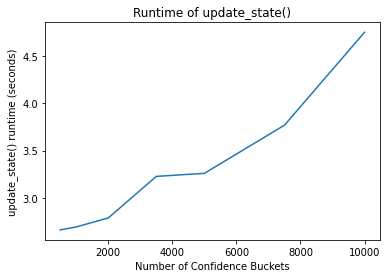

In [ ]:
sns.lineplot(data=data, x="bucket_values", y="update_state_runtimes")
plt.xlabel("Number of Confidence Buckets")
plt.ylabel("update_state() runtime (seconds)")
plt.title("Runtime of update_state()")
plt.show()

## result()

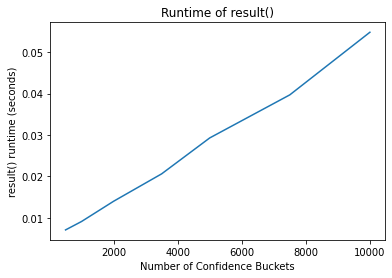

In [ ]:
sns.lineplot(data=data, x="bucket_values", y="result_runtimes")
plt.xlabel("Number of Confidence Buckets")
plt.ylabel("result() runtime (seconds)")
plt.title("Runtime of result()")
plt.show()

# End to End Runs

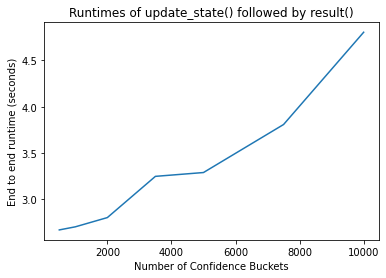

In [ ]:
sns.lineplot(data=data, x="bucket_values", y="end_to_end_runtimes")
plt.xlabel("Number of Confidence Buckets")
plt.ylabel("End to end runtime (seconds)")
plt.title("Runtimes of update_state() followed by result()")
plt.show()